In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import normaltest

In [2]:
path = "C:/Users/amols/OneDrive/Documents/ProbStatForDS/ECE225Project/Store-item-sales-prediction-data/"

train_data = pd.read_csv(path+'train.csv',parse_dates=['date'],index_col='date')
test_data = pd.read_csv(path+'test.csv',parse_dates=['date'],index_col='date')

sales = train_data[(train_data['store']==1)&(train_data['item']==1)]['sales']

In [3]:
plt.rcParams["figure.figsize"] = [12,7]

C:\Users\amols\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


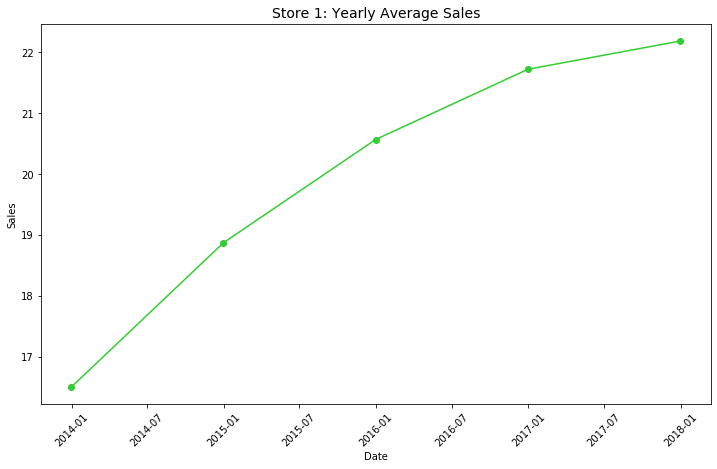

In [4]:
x = sales.groupby(pd.Grouper(freq='Y')).mean()
plt.plot(x,color='limegreen', marker = 'o')
plt.xlabel('Date',fontsize=10)
plt.ylabel('Sales',fontsize=10)
plt.xticks(rotation=45,fontsize=10)
plt.title('Store 1: Yearly Average Sales',fontsize=14)
plt.show()

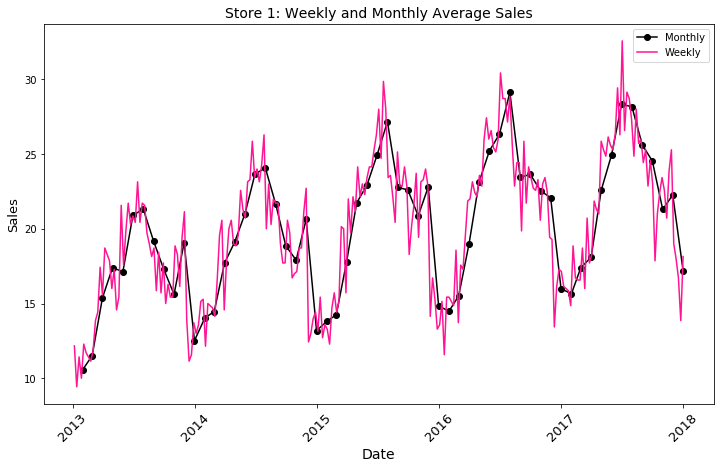

In [5]:

plt.plot(sales.groupby(pd.Grouper(freq='M')).mean(),color='black',marker = 'o',label='Monthly')
plt.xlabel('Date',fontsize=10)
plt.ylabel('Sales',fontsize=10)
plt.xticks(rotation=45,fontsize=10)
#plt.title('Monthly Average',fontsize=14)

plt.plot(sales.groupby(pd.Grouper(freq='W')).mean(),color='deeppink',label='Weekly')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Sales',fontsize=13)
plt.xticks(rotation=45,fontsize=13)
plt.title('Store 1: Weekly and Monthly Average Sales',fontsize=14)
plt.legend(fontsize=10)
plt.show()

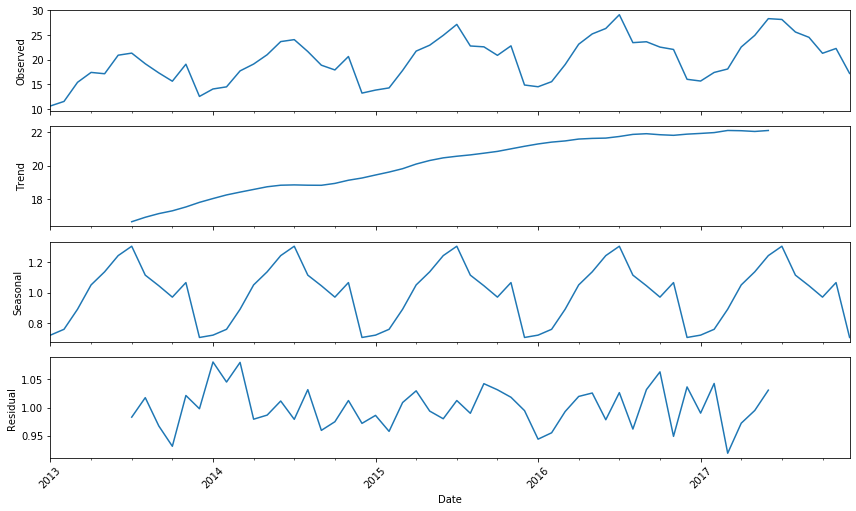

In [6]:
decomposition = seasonal_decompose(sales.groupby(pd.Grouper(freq='M')).mean(),model='multiplicative')
decomposition.plot()
plt.plot(color='r')
plt.xlabel('Date',fontsize=10)
plt.xticks(rotation=45,fontsize=10)
plt.show()

C:\Users\amols\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Text(0.5, 1.0, 'Store 1: Daywise Average Sales')

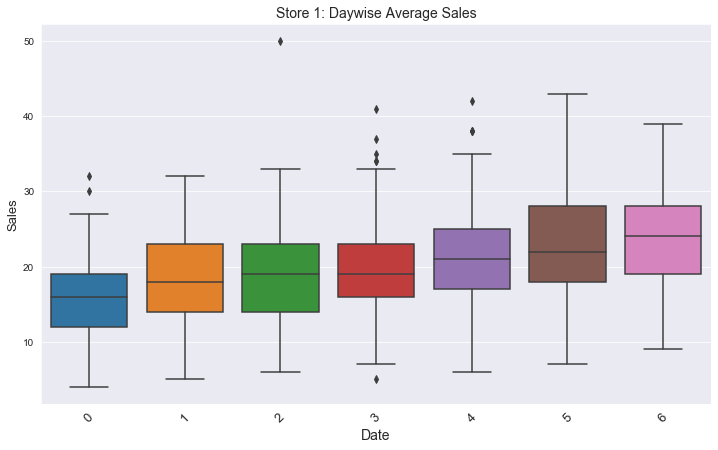

In [12]:
df =train_data
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
color = sns.color_palette()
sns.set_style('darkgrid')

train = pd.read_csv(path+'train.csv',parse_dates=['date'])
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]

train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday

sns.boxplot(x="weekday", y="sales", data=train_df)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Sales',fontsize=13)
plt.xticks(rotation=45,fontsize=13)
plt.title('Store 1: Daywise Average Sales',fontsize=14)

In [8]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='plum',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best',fontsize=13)
    plt.xlabel('Day Index',fontsize=14)
    plt.ylabel('Sales',fontsize=13)
    plt.title('Result of Dickey-Fuller Test',weight='bold',fontsize=14)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]   
    print(dfoutput)

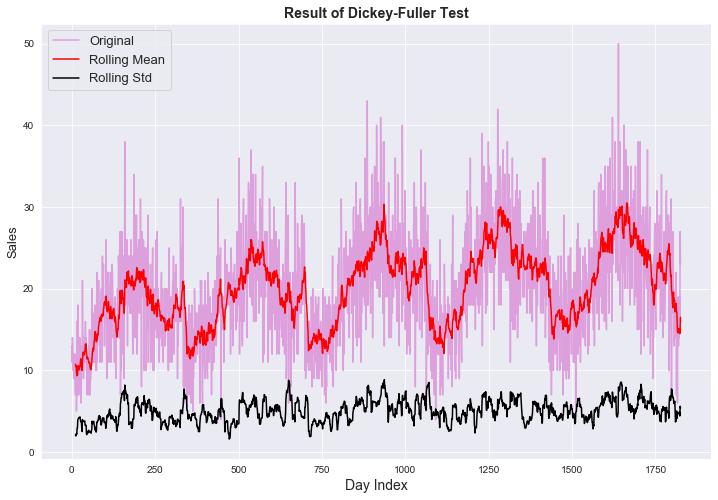

Results of Dickey-Fuller Test:
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


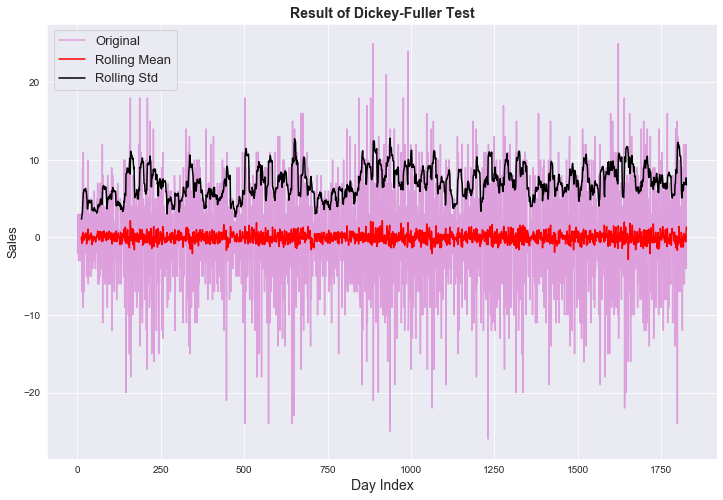

Results of Dickey-Fuller Test:
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [9]:

test_stationarity(train_df['sales'])
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

Text(0.5, 1.0, 'Autocorrelation')

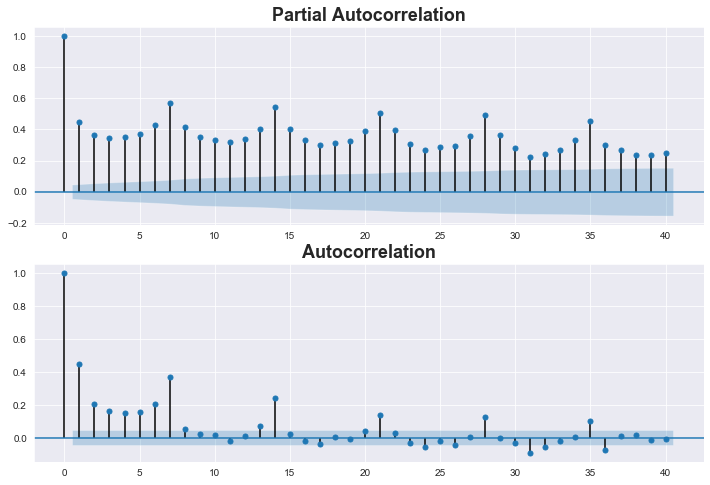

In [10]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) # 
plt.title('Partial Autocorrelation',weight='bold',fontsize=18)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)# 
plt.title('Autocorrelation',weight='bold',fontsize=18)

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Sun, 15 Dec 2019   AIC                          11211.335
Time:                        18:55:53   BIC                          11255.410
Sample:                             1   HQIC                         11227.594
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

Text(0.5, 1.0, 'Residual distribution')

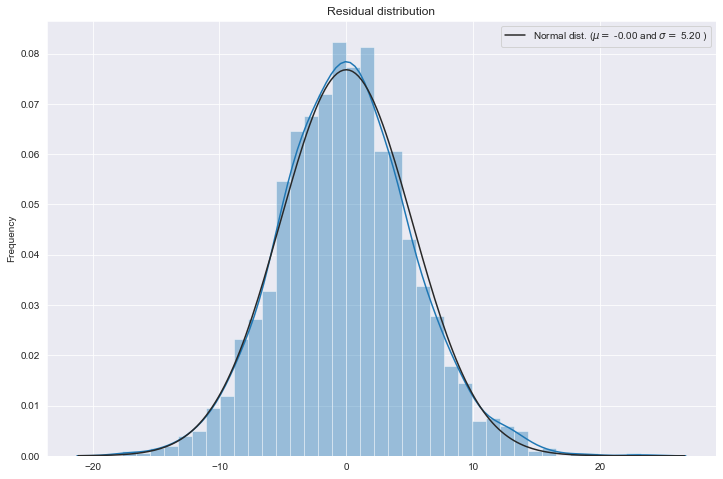

In [11]:
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

In [13]:
df = pd.read_csv(path +'train.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.tail()

,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82
